# <center>ЗАДАЧА ДЛЯ САМОСТОЯТЕЛЬНОГО ПРОЕКТА</center>

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.



In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import seasonal_decompose, ARIMA, adfuller
from pmdarima import auto_arima

warnings.filterwarnings('ignore')
pio.templates.default = 'plotly_dark'
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
data = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col='year').rename(columns={'GDP (current US$)': 'GDP'})
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


## Разложение данных на тренд, сезонность и шум.

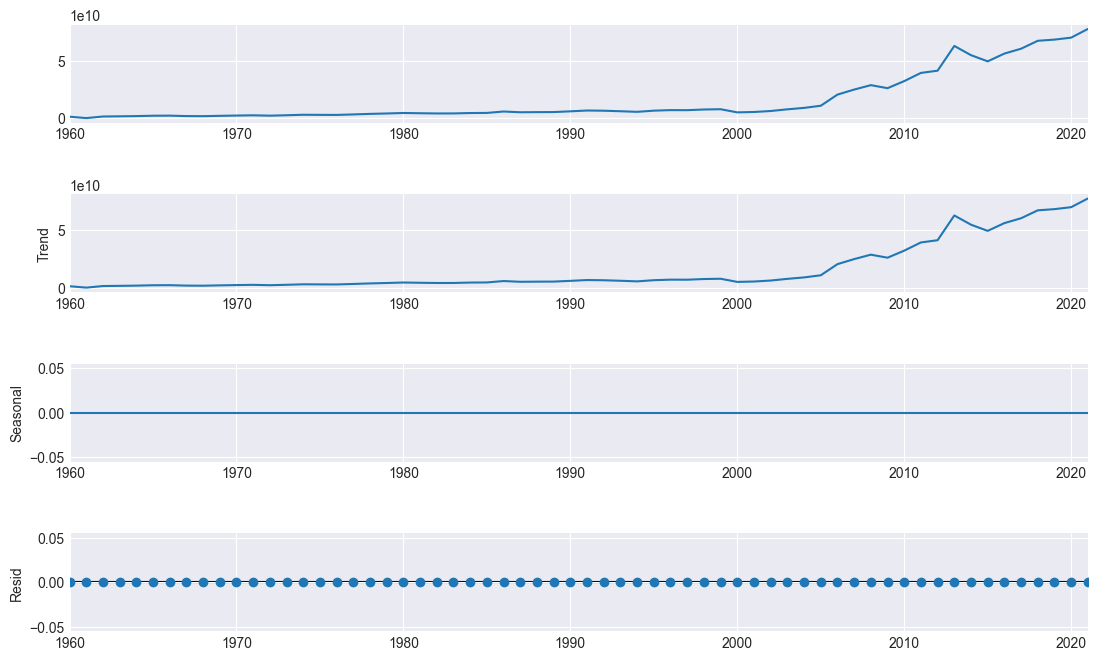

In [3]:
decomposed_data = seasonal_decompose(data)
figure = decomposed_data.plot()
figure.set_figwidth(12)
figure.set_figheight(7)
plt.show();

В данных есть тренд (график которого совпадает с графиком исходных данных), полностью отсутствует сезонность, шум находится в нуле.

Разделим выборку на *train* и *test*, в тестовой оставим последние 3 года.

In [4]:
train, test = data[data.index.year < 2019], data[data.index.year >= 2019]
print(
    'Train shape:', train.shape,
    '\nTest shape:', test.shape
)

Train shape: (59, 1) 
Test shape: (3, 1)


## Построение графика скользящего среднего

In [99]:
rolling_data = data.rolling(window=3).mean()
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=data.index,
        y=data.GDP,
        name='Data',
        mode='lines+markers',
        line=dict(color='white')
    )
).update_layout(
    width=1200,
    height=700,
    title='<b>Исходный временной ряд vs. скользящее среднее</b>',
    xaxis_title='GDP',
    yaxis_title='Year',
    font=dict(size=16)
)

for window in range(2, 7, 2):
    rolling_data = data.rolling(window=window).mean()
    fig.add_trace(
        go.Line(
            x=rolling_data.index,
            y=rolling_data.GDP,
            name=f'Rolling mean<br>(window={window})',
        )
    )

fig.show()

Скользящее среднее с окном 3 довольно хорошо описывает исходные данные, но есть некоторые неточности, например, промежуток между 2013 и 2015 годами.

## Оценка ряда на стационарность, выбор модели *ARMA/ARIMA*

In [89]:
adfuller_result = adfuller(data)
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


Количество дифференцирований, необходимых для сведения ряда к стационарному: 3


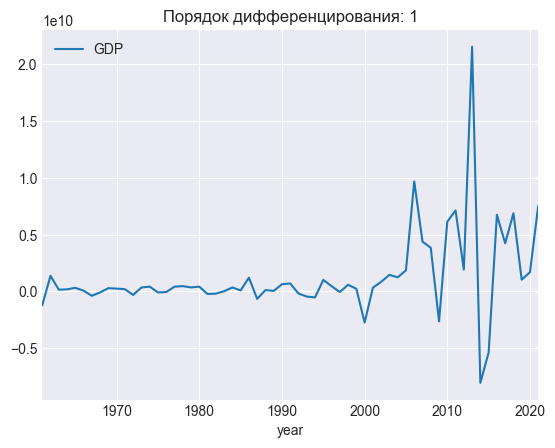

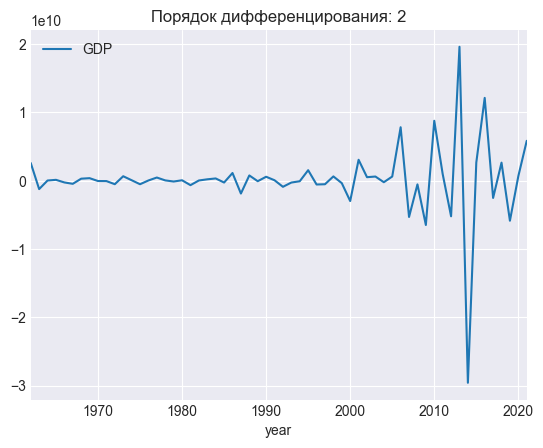

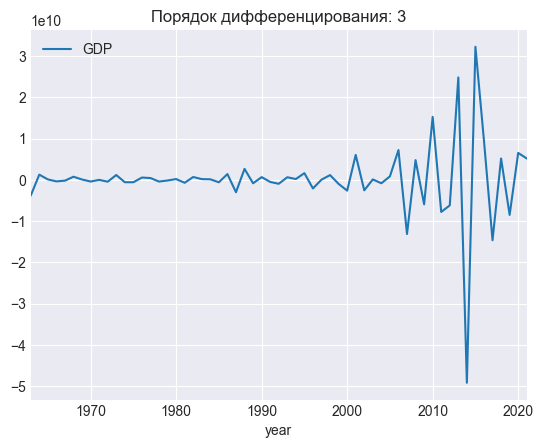

In [107]:
def get_num_of_diffs(data):
    n_diff = 0
    data_diff = data.diff().dropna()
    while True:
        n_diff += 1
        adfuller_result = adfuller(data_diff)
        data_diff.plot().set_title(f'Порядок дифференцирования: {n_diff}')
        if adfuller_result[0] <= adfuller_result[4]['10%']:
            break
        data_diff = data_diff.diff().dropna()

    print(f'Количество дифференцирований, необходимых для сведения ряда к стационарному: {n_diff}')
    return n_diff
plt.show()
d = get_num_of_diffs(data)

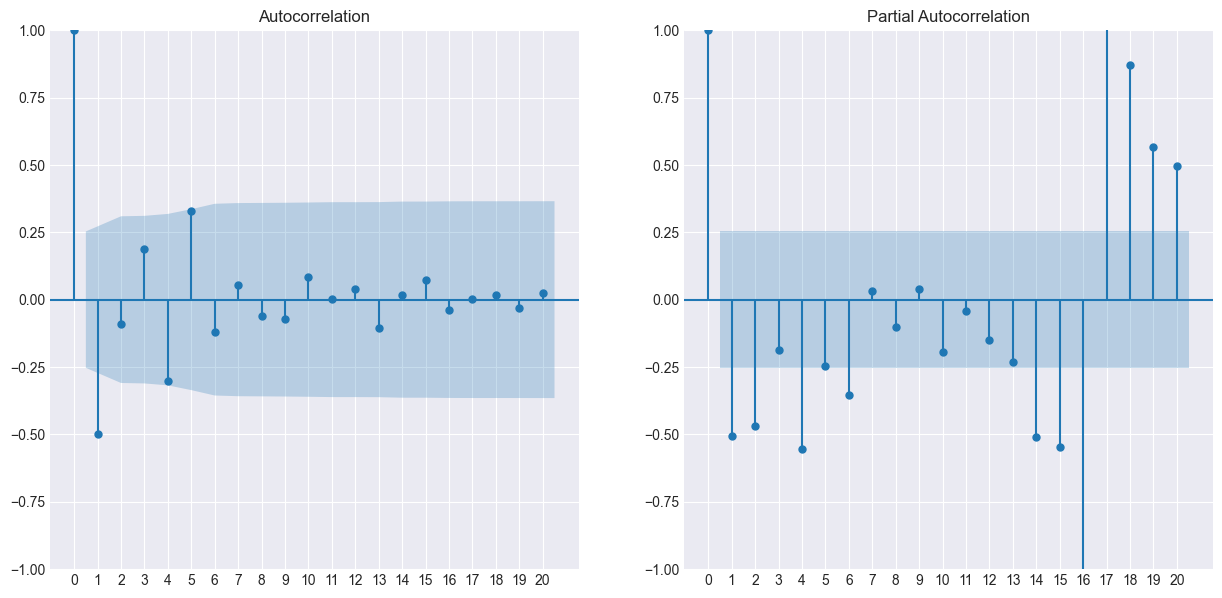

In [139]:
data_diff = data['GDP'].diff().diff().dropna()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
plot_acf(x=data_diff, ax=ax[0], lags=20)
plot_pacf(x=data_diff, ax=ax[1], lags=20)
ax[0].xaxis.set_ticks(range(0, 21))
ax[1].xaxis.set_ticks(range(0, 21))
plt.show()